In [1]:
import numpy as np
import pandas as pd
import os
import pystan
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from seaborn import kdeplot

In [2]:
# Import data and process as in stan_models
df = pd.concat(pd.read_csv(os.path.join('data', filename), index_col=0) for filename in os.listdir('data') if filename.endswith('.csv'))

# change data type on a couple of variables
df['explicit'] = df['explicit'].astype('int')
df['release_date'] = pd.to_datetime(df['release_date'], yearfirst=True)


# Modify some variables so they make more sense in regression context

# is 4:4?
df['time_signature_4'] = (df['time_signature'] == 4).astype('int')
# difference between data collection date and release date
df['days_since_release'] = (pd.to_datetime('2020-03-11') - df['release_date']).apply(lambda x: x.days)
# Express durations in seconds, not milliseconds
df['duration_s'] = df['duration_ms']/1000

# drop messed up entries
df.dropna(inplace=True)


features = ['availability', 'explicit', 'track_number', 'days_since_release', 'num_artists', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s', 'time_signature_4']
X = df[features].values
y = df['popularity'].values

# I need to scale the data before putting into the stan model:
X_scaled = np.empty(X.shape)
for k in range(X.shape[1]):
    X_scaled[:,k] = (X[:,k] - X[:,k].mean()) / X[:,k].std()

# Split train and test data, leave 20% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=152)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [3]:
# Define model as in stan_models, but include generated quantities
# Also assume X is scaled before inputting
model_str = '''
data {
    int<lower=0> N; // number of songs in train set
    int<lower=0> K; // number of regression vars
    vector[N] y; // dependent variable
    matrix[N, K] X; // independent variables
    int<lower=0> M; // number of songs in test set
    matrix[M, K] X_test;
}

transformed data {
    matrix[N, K] Q_star;
    matrix[K, K] R_star;
    matrix[K, K] R_star_inverse;
    // get QR decomposition
    // thin and scale the QR decomposition
    Q_star = qr_thin_Q(X) * sqrt(N - 1);
    R_star = qr_thin_R(X) / sqrt(N - 1);
}

parameters {
    real alpha; // the intercept
    vector[K] theta; // the coeffs on Q_star
    real<lower=0> sigma_raw; // st dev of error
    real<lower=0> nu; // degrees of freedom
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sigma_raw * sqrt((nu - 2) / nu);
}

model {
    // priors
    alpha ~ normal(mean(y), 10);
    theta ~ normal(0, 1000);
    sigma_raw ~ cauchy(0, 5);
    nu ~ gamma(2, 0.1);
    // likelihood
    y ~ student_t(nu, alpha + Q_star * theta, sigma);
}

generated quantities {
    vector[K] beta; // the coeffs on X
    beta = R_star \ theta;
}
'''


data = {
    'N': X_train.shape[0],
    'K': X_train.shape[1],
    'y': y_train,
    'X': X_train,
    'M': X_test.shape[0],
    'X_test': X_test
}

model_file = 'crossval_model.pkl'
if os.path.isfile(model_file):
    with open(model_file, 'rb') as fh:
        model = pickle.load(fh)
else:
    model = pystan.StanModel(model_code=model_str)
    with open(model_file, 'wb') as fh:
        pickle.dump(model, fh)

fit_file = 'crossval_fit.pkl'
if os.path.isfile(fit_file):
    with open(fit_file, 'rb') as fh:
        fit = pickle.load(fh)
else:
    fit = model.sampling(data=data, iter=10000, warmup=1000, chains=2)
    with open(fit_file, 'wb') as fh:
        pickle.dump(fit, fh)

In [4]:
# Make sure everything looks similar to before
print(fit.stansummary())

Inference for Stan model: anon_model_5bff03ec64b90b370221cf34d8881277.
2 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=18000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      26.06  4.1e-4   0.08   25.9  26.01  26.06  26.11  26.22  38582    1.0
theta[1]    9.64  4.0e-4   0.08   9.48   9.59   9.64   9.69    9.8  40669    1.0
theta[2]    5.52  4.1e-4   0.08   5.36   5.46   5.52   5.57   5.68  39769    1.0
theta[3]   -4.94  4.3e-4   0.08   -5.1  -4.99  -4.94  -4.88  -4.78  35796    1.0
theta[4]   -3.15  4.2e-4   0.08  -3.31   -3.2  -3.15   -3.1  -2.99  36276    1.0
theta[5]   -0.45  3.8e-4   0.08  -0.61  -0.51  -0.45   -0.4  -0.29  45590    1.0
theta[6]    2.04  4.0e-4   0.08   1.88   1.99   2.04    2.1    2.2  40443    1.0
theta[7]     2.9  4.1e-4   0.08   2.74   2.84    2.9   2.95   3.06  38121    1.0
theta[8]    4.13  4.0e-4   0.08   3.97   4.08   4.13   4.19   4.29  40704    1.0

### Compute goodness of fit statistics for fitted linear model

In [5]:
params = fit.extract(pars=['nu', 'alpha', 'beta', 'sigma'])
nparams = len(params['nu'])

In [6]:
def get_samples(nrow, ncol):
    # draw random sample of indices
    indices = np.random.choice(nparams, nrow*ncol, replace=True)
    nu = params['nu'][indices].reshape(nrow, ncol)
    alpha = params['alpha'][indices].reshape(nrow, ncol)
    beta = params['beta'][indices].reshape(nrow, ncol, -1)
    sigma = params['sigma'][indices].reshape(nrow, ncol)
    return nu, alpha, beta, sigma

def sample_posterior(X, samples=100):
    nu, alpha, beta, sigma = get_samples(X.shape[0], samples)
    y_pred = np.random.standard_t(df=nu) * sigma + alpha
    for i in range(X.shape[0]):
        for j in range(samples):
            y_pred[i,j] += X[i].dot(beta[i,j,:])
    return y_pred

def calculate_mean_squared_deviations(y, y_pred):
    return np.mean((y_pred.T - y)**2)

In [7]:
# calculate mse on training set
y_pred0 = sample_posterior(X_train)  # generates 10430 x 100 array
meansq_loss0 = calculate_mean_squared_deviations(y_train, y_pred0)
print(f'mean squared error loss for train set is {meansq_loss0}')

mean squared error loss for train set is 535.3173013029136


In [8]:
# calculate mse for test set
y_pred = sample_posterior(X_test)  # generates 10430 x 100 array
meansq_loss = calculate_mean_squared_deviations(y_test, y_pred)
print(f'mean squared error loss for test set is {meansq_loss}')

mean squared error loss for test set is 540.3584716895426


In [9]:
from scipy.stats import t

def posterior_predictive_density(X, y, samples=5):
    nu, alpha, beta, sigma = get_samples(X.shape[0], samples)
    ppd = 0
    for i in range(X.shape[0]):
        ppd += np.log(sum(t.pdf(y[i], df=nu[i,j], loc=alpha[i,j] + X[i].dot(beta[i,j,:]), scale=sigma[i,j]) \
                             for j in range(samples)) / samples)
    return ppd

In [10]:
# ppd for train set
ppd0 = posterior_predictive_density(X_train, y_train, samples=2)
print(f'ppd for train set is {ppd0}')
print(f'average ppd for sample in train set is {ppd0 / X_train.shape[0]}')

ppd for train set is -175790.7456669854
average ppd for sample in train set is -4.21388751988363


In [11]:
ppd = posterior_predictive_density(X_test, y_test)
print(f'ppd for test set is {ppd}')
print(f'average ppd for sample in test set is {ppd / X_test.shape[0]}')

ppd for test set is -44013.432911657095
average ppd for sample in test set is -4.219888102747564


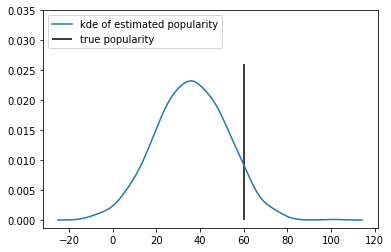

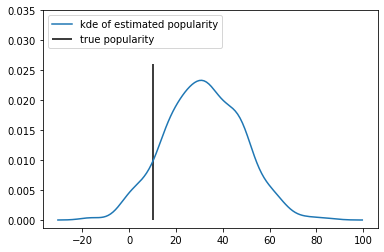

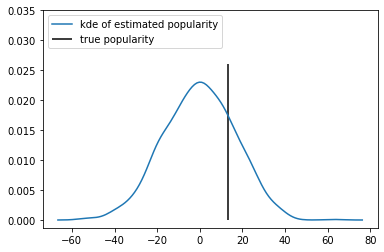

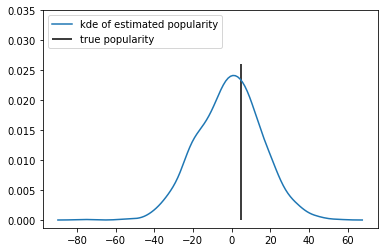

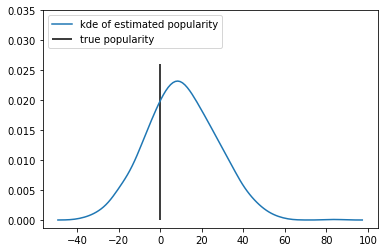

In [12]:
# Show posterior distributions for a few values
y_ex = sample_posterior(X_test[:5], samples=1000)
for y_pred, y_true in zip(y_ex, y_test[:5]):
    kdeplot(y_pred, label='kde of estimated popularity')
    plt.vlines(y_true, 0, 0.026, label='true popularity')
    plt.ylim(top=0.035)
    plt.legend(loc='upper left')
    plt.show()

### Fitting the same model with variational inference

In [13]:
import pymc3 as pm

with pm.Model() as linear_model:
    alpha = pm.Normal('alpha', mu=y_train.mean(), sigma=1000)
    beta = pm.Normal('beta', mu=0, sigma=1000, shape=X_train.shape[1])
    sigma = pm.HalfCauchy('sigma', 5)
    nu = pm.Gamma('nu', 2, 0.1)
    y = pm.StudentT('y', nu=nu, mu=alpha + pm.math.dot(X_train, beta), sigma=sigma,
                    observed=y_train)
    fit = pm.fit(30000, method='fullrank_advi')
    svi_trace = fit.sample(2000)

Average Loss = 1.7599e+05: 100%|██████████| 30000/30000 [02:22<00:00, 209.87it/s]
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 1.7599e+05


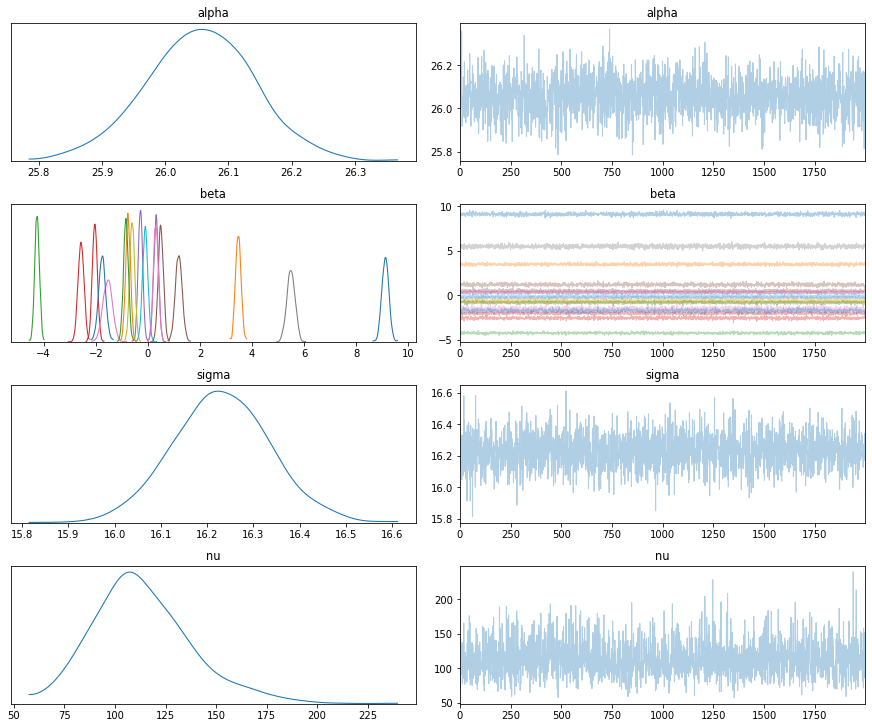

In [14]:
pm.traceplot(svi_trace, figsize=(12,10))
plt.show()

In [15]:
pm.summary(svi_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,26.054,0.085,25.893,26.216,0.002,0.001,1985.0,1985.0,1986.0,1653.0,NaN
beta[0],9.115,0.133,8.868,9.357,0.003,0.002,1837.0,1837.0,1832.0,1819.0,NaN
beta[1],3.470,0.105,3.267,3.652,0.002,0.002,1946.0,1946.0,1946.0,1821.0,NaN
beta[2],-4.257,0.088,-4.423,-4.095,0.002,0.001,1738.0,1738.0,1735.0,1720.0,NaN
beta[3],-2.039,0.094,-2.213,-1.860,0.002,0.001,2003.0,2003.0,2008.0,1811.0,NaN
beta[4],-0.287,0.084,-0.451,-0.138,0.002,0.001,1943.0,1943.0,1947.0,1576.0,NaN
beta[5],1.183,0.129,0.942,1.429,0.003,0.002,1971.0,1971.0,1972.0,1768.0,NaN
beta[6],-1.549,0.179,-1.863,-1.202,0.004,0.003,2001.0,1996.0,1998.0,2028.0,NaN
beta[7],5.491,0.154,5.212,5.788,0.003,0.002,2027.0,2021.0,2028.0,1984.0,NaN
beta[8],-0.601,0.093,-0.774,-0.424,0.002,0.002,1790.0,1776.0,1808.0,1850.0,NaN


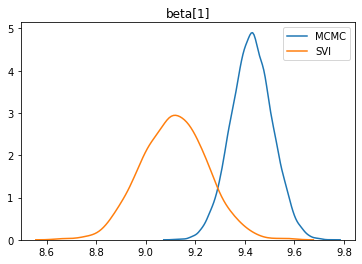

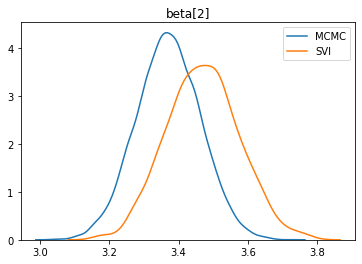

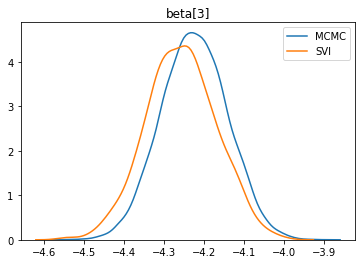

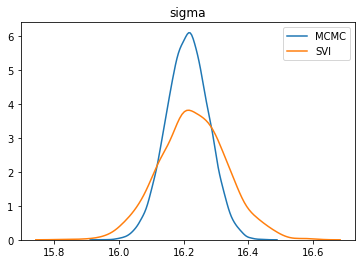

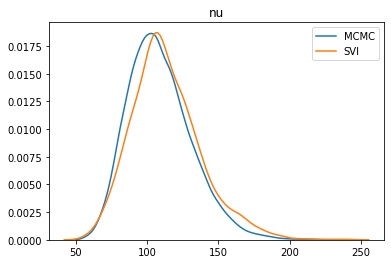

In [16]:
# compare distributions from MCMC and SVI
kdeplot(params['beta'][:,0], label='MCMC')
kdeplot(svi_trace.beta[:,0], label='SVI')
plt.title('beta[1]')
plt.show()

kdeplot(params['beta'][:,1], label='MCMC')
kdeplot(svi_trace.beta[:,1], label='SVI')
plt.title('beta[2]')
plt.show()

kdeplot(params['beta'][:,2], label='MCMC')
kdeplot(svi_trace.beta[:,2], label='SVI')
plt.title('beta[3]')
plt.show()

kdeplot(params['sigma'], label='MCMC')
kdeplot(svi_trace.sigma, label='SVI')
plt.title('sigma')
plt.show()

kdeplot(params['nu'], label='MCMC')
kdeplot(svi_trace.nu, label='SVI')
plt.title('nu')
plt.show()

In [17]:
svi_trace.beta.shape

(2000, 17)

#### Attempting to use Pyro for SVI

In [18]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro import infer
from pyro import optim
from pyro.nn import PyroModule, PyroSample
from pyro.contrib.bnn import HiddenLayer

In [19]:
class BayesianRegression(PyroModule):
    
    def __init__(self, X_train, y_train):
        super().__init__()
        self.X_train = torch.from_numpy(X_train).float()
        self.y_train = torch.from_numpy(y_train).float()
        self.n_features = self.X_train.size(1)
        self.weight_loc = torch.zeros(self.n_features, 1)
        self.weight_scale = 100 * torch.ones(self.n_features, 1)
        self.bias_loc = self.y_train.mean()
        self.bias_scale = torch.tensor(10.)
        #self.guide = infer.autoguide.AutoMultivariateNormal(self)
    
    def forward(self, X, y=None):
        weight = pyro.sample('weight', dist.Normal(self.weight_loc, self.weight_scale))
        bias = pyro.sample('bias', dist.Normal(self.bias_loc, self.bias_scale))
        df = pyro.sample('df', dist.HalfCauchy(scale=5))
        sigma = pyro.sample('sigma', dist.Gamma(2, 0.1))
        mean = (torch.matmul(X, weight) + bias).flatten()
        with pyro.plate('data', X.size(0)):
            obs = pyro.sample('obs', dist.StudentT(df=df, loc=mean, scale=sigma), obs=y)
    
    def guide(self, X, y=None):
        weight_loc = pyro.param('weight_loc', torch.zeros(self.n_features, 1))
        weight_scale = pyro.param('weight_scale', torch.ones(self.n_features, 1),
                                  constraint=constraints.positive)
        bias_loc = pyro.param('bias_loc', torch.tensor(0.))
        bias_scale = pyro.param('bias_scale', torch.tensor(1.),
                                constraint=constraints.positive)
        df_scale = pyro.param('cauchy_scale', torch.tensor(5.),
                              constraint=constraints.positive)
        sigma_a = pyro.param('sigma_a', torch.tensor(2.),
                             constraint=constraints.positive)
        sigma_b = pyro.param('sigma_b', torch.tensor(0.1),
                             constraint=constraints.positive)
        weight = pyro.sample('weight', dist.Normal(weight_loc, weight_scale))
        bias = pyro.sample('bias', dist.Normal(bias_loc, bias_scale))
        df = pyro.sample('df', dist.HalfCauchy(scale=df_scale))
        sigma = pyro.sample('sigma', dist.Gamma(sigma_a, sigma_b))
        mean = (torch.matmul(X, weight) + bias).flatten()
        
    def fit(self, optimizer=optim.Adam, optimizer_params={'lr': 0.01},
            batch_size=128, n_epochs=10):
        svi = infer.SVI(self, self.guide, optimizer(optimizer_params), infer.Trace_ELBO())
        total_size = self.X_train.size(0)
        pyro.clear_param_store()
        for i in range(n_epochs):
            loss = 0
            for j in np.arange(total_size, step=batch_size):
                X, y = self.X_train[j:j+batch_size], self.y_train[j:j+batch_size]
                loss += svi.step(X, y)
            print(f'Epoch {i+1}: average loss = {loss / total_size:.5E}')
            
    def predict(self, X, n_samples=100, return_sites=('obs',)):
        predictive = infer.Predictive(self, guide=self.guide, num_samples=n_samples,
                                      return_sites=return_sites)
        if X.dim() == self.n_features:
            X = X.unsqueeze(0)
        with torch.no_grad():
            pred = predictive(X)
        if return_sites == ('obs',):
            return pred['obs'].squeeze()
        else:
            return {k: pred[k].squeeze() for k in pred.keys()}

In [20]:
bayesianRegression = BayesianRegression(X_train, y_train)
bayesianRegression.fit(optimizer_params={'lr': 0.02}, n_epochs=20)

Epoch 1: average loss = 5.86630E+00
Epoch 2: average loss = 5.50334E+00
Epoch 3: average loss = 5.38326E+00
Epoch 4: average loss = 5.12259E+00
Epoch 5: average loss = 5.02682E+00
Epoch 6: average loss = 4.94499E+00
Epoch 7: average loss = 4.89145E+00
Epoch 8: average loss = 4.87196E+00
Epoch 9: average loss = 4.85471E+00
Epoch 10: average loss = 4.86083E+00
Epoch 11: average loss = 4.85450E+00
Epoch 12: average loss = 4.84571E+00
Epoch 13: average loss = 4.84712E+00
Epoch 14: average loss = 4.84430E+00
Epoch 15: average loss = 4.83851E+00
Epoch 16: average loss = 4.84934E+00
Epoch 17: average loss = 4.83836E+00
Epoch 18: average loss = 4.84220E+00
Epoch 19: average loss = 4.84210E+00
Epoch 20: average loss = 4.83489E+00


In [21]:
# I'm not sure if I've gotten this working properly yet
y_pred = bayesianRegression.predict(torch.from_numpy(X_test).float())
print(f'mean squared error loss for test set is {((y_pred - y_test)**2).mean()}')

mean squared error loss for test set is 680.5997300546888


In [22]:
# Sample betas
# Betas don't depend on X's, so I can just give it some random input
# beta_pred = bayesianRegression.predict(torch.randn(1, 17), n_samples=1000,
#                                        return_sites=('weight',))['weight']
# beta_mcmc = params['beta'][np.random.choice(nparams, 1000, replace=True)].reshape(1000, -1)
# for i in range(beta_pred.size(1)):
#     kdeplot(np.array(beta_pred[:,i]), label='variational')
#     kdeplot(beta_mcmc[:,i], label='mcmc')
#     plt.title(f'beta {i+1}')
#     plt.show()

In [23]:
# y_ex = bayesianRegression.predict(torch.from_numpy(X_test[:5]).float(), n_samples=1000)
# for y_pred, y_true in zip(np.array(y_ex).T, y_test[:5]):
#     kdeplot(y_pred, label='kde of estimated popularity')
#     plt.vlines(y_true, 0, 0.03, label='true popularity')
#     plt.ylim(top=0.035)
#     plt.xlim(0, 100)
#     plt.legend(loc='upper left')
#     plt.show()

### Neural network for better fit (maybe?)

In [24]:
class BayesianLinear(nn.Linear, PyroModule):
    """Linear layer with weights as normal random variables"""
    
    def __init__(self, n_in, n_out, sd=1):
        super().__init__(n_in, n_out)
        self.weight = PyroSample(
            prior = dist.Normal(0, sd).expand([n_out, n_in]).to_event(2)
        )
        self.bias = PyroSample(prior = dist.Normal(0, sd).expand([n_out]).to_event(1))

    
# Next create version with weights as random variables
class BayesianNet(PyroModule):
    """Basic neural network with Pyro functionality
    ! Currently doesn't allow more than 2 hidden layers
    ! it's a problem with the automatic naming feature of the PyroSample class
    
    Takes vector input of size num_features, outputs scalar
    """
    
    def __init__(self, num_features, hidden_sizes=[10, 10], autoguide_rank=100):
        super().__init__()
        self.hidden_sizes = hidden_sizes
        self.num_features = num_features
        self.input_layer = BayesianLinear(num_features, hidden_sizes[0])
        self.hidden_layers = [
            BayesianLinear(hidden_sizes[i], hidden_sizes[i+1]) \
                for i in range(len(hidden_sizes) - 1)
        ]
        self.output_layer = BayesianLinear(hidden_sizes[-1], 1)
        # Create params for df and sigma, same priors as above
        self.df = PyroSample(prior=dist.HalfCauchy(scale=5))
        self.sigma = PyroSample(prior=dist.Gamma(2, 0.1))
        # Calculate total params
        total_params = num_features * (hidden_sizes[0] + 1) \
                        + sum(hidden_sizes[i] * (hidden_sizes[i+1] + 1) \
                              for i in range(len(hidden_sizes) -1)) \
                        + hidden_sizes[-1] * 2 + 2
        print(f'total params is {total_params}')
        # Use multivariate normal distribution as guide for variational inference
        self.guide = infer.autoguide.AutoLowRankMultivariateNormal(
            self, init_loc_fn=infer.autoguide.init_to_sample, rank=autoguide_rank
        )
        
    
    def forward(self, x, y=None):
        x = nn.functional.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = nn.functional.relu(layer(x))
        # No rectifier on output layer
        x = self.output_layer(x)
        df = self.df
        sigma = self.sigma
        with pyro.plate('sample_obs', x.size(0)):
            return pyro.sample('obs', dist.StudentT(df=df, loc=x, scale=sigma).to_event(1), obs=y)
    
    def fit(self, X_train, y_train, optimizer=optim.Adam, optimizer_params={'lr': 0.01},
            batch_size=128, n_epochs=10):
        svi = infer.SVI(self, self.guide, optimizer(optimizer_params), infer.Trace_ELBO())
        X_train = torch.from_numpy(X_train).float()
        y_train = torch.from_numpy(y_train).float()
        total_size = X_train.size(0)
        for i in range(n_epochs):
            loss = 0
            for j in np.arange(total_size, step=batch_size):
                X, y = X_train[j:j+batch_size], y_train[j:j+batch_size]
                loss += svi.step(X, y)
            print(f'Epoch {i+1}: average loss = {loss / total_size:.5E}')
    
    def predict(self, X, n_samples=100, return_sites=('obs',)):
        predictive = infer.Predictive(self, guide=self.guide, num_samples=n_samples,
                                      return_sites=return_sites)
        if X.dim() == self.num_features:
            X = X.unsqueeze(0)
        with torch.no_grad():
            pred = predictive(X)
        if return_sites == ('obs',):
            return pred['obs'].squeeze()
        else:
            return {k: pred[k].squeeze() for k in pred.keys()}

In [25]:
class UpgradedBayesian(nn.Module):
    """Bayesian NN with student t-distributed scalar output
    
    Doesn't really work right now :( Use BayesianNet instead
    """
    
    def __init__(self, n_features, hidden_sizes=[10,10]):
        super().__init__()
        self.n_features = n_features
        self.hidden_sizes = hidden_sizes
        self.n_hidden = len(hidden_sizes)
        # Set up coefficients for weights
        self.inp_mean = torch.zeros(n_features, self.hidden_sizes[0])
        self.inp_scale = torch.ones(n_features, self.hidden_sizes[0])
        self.hidden_means = [
            torch.zeros(self.hidden_sizes[i]+1, self.hidden_sizes[i+1]) \
                for i in range(self.n_hidden - 1)
        ]
        self.hidden_scales = [
            torch.ones(self.hidden_sizes[i]+1, self.hidden_sizes[i+1]) \
                for i in range(self.n_hidden - 1)
        ]
        self.out_mean = torch.zeros(self.hidden_sizes[self.n_hidden-1]+1, 1)
        self.out_scale = torch.ones(self.hidden_sizes[self.n_hidden-1]+1, 1)
    
    def forward(self, X, y=None, kl_factor=1.0):
        # Sample from all layers
        x = pyro.sample('h_inp', HiddenLayer(X, self.inp_mean, self.inp_scale, KL_factor=kl_factor))
        for i in range(self.n_hidden - 1):
            x = pyro.sample(
                f'h_{i+1}',
                HiddenLayer(x, self.hidden_means[i], self.hidden_scales[i], KL_factor=kl_factor)
            )
        x = pyro.sample(
            'h_out',
            HiddenLayer(x, self.out_mean, self.out_scale,
                        non_linearity=nn.Identity(), KL_factor=kl_factor,
                        include_hidden_bias=False)
        ).flatten()
        # Sample df and sigma
        df = pyro.sample('df', dist.HalfCauchy(scale=5))
        sigma = pyro.sample('sigma', dist.Gamma(2, 0.1))
        with pyro.plate('data', size=X.size(0)):
            # Return student-t draw
            return pyro.sample('out', dist.StudentT(df=df, loc=x, scale=sigma), obs=y)
    
    def guide(self, X, y=None, kl_factor=1.0):
        # Define random initialization sites for parameters
        inp_mean = pyro.param('inp_mean', 0.01 * torch.randn_like(self.inp_mean))
        inp_scale = pyro.param('inp_scale', 0.1 * torch.ones_like(self.inp_scale),
                               constraint=constraints.positive)
        hidden_means = [
            pyro.param(f'hidden{i}_mean', 0.01 * torch.randn_like(self.hidden_means[i])) \
                for i in range(self.n_hidden - 1)
        ]
        hidden_scales = [
            pyro.param(f'hidden{i}_scale', 0.1 * torch.ones_like(self.hidden_scales[i]),
                       constraint=constraints.positive) \
                for i in range(self.n_hidden - 1)
        ]
        out_mean = pyro.param('out_mean', 0.01 * torch.randn_like(self.out_mean))
        out_scale = pyro.param('out_scale', 0.1 * torch.ones_like(self.out_scale),
                               constraint=constraints.positive)
        df_shape = pyro.param('df_shape', torch.tensor(1.), constraint=constraints.positive)
        df_rate = pyro.param('df_rate', torch.tensor(0.5), constraint=constraints.positive)
        sigma_shape = pyro.param('sigma_shape', torch.tensor(1.), constraint=constraints.positive)
        sigma_rate = pyro.param('sigma_rate', torch.tensor(0.5), constraint=constraints.positive)
        # Sample from all layers
        x = pyro.sample('h_inp', HiddenLayer(X, self.inp_mean, self.inp_scale, KL_factor=kl_factor))
        for i in range(self.n_hidden - 1):
            x = pyro.sample(
                f'h_{i+1}',
                HiddenLayer(x, self.hidden_means[i], self.hidden_scales[i], KL_factor=kl_factor)
            )
        x = pyro.sample(
            'h_out',
            HiddenLayer(x, self.out_mean, self.out_scale,
                        non_linearity=nn.Identity(), KL_factor=kl_factor,
                        include_hidden_bias=False)
        ).flatten()
        # Sample df and sigma
        df = pyro.sample('df', dist.Gamma(df_shape, df_rate))
        sigma = pyro.sample('sigma', dist.Gamma(sigma_shape, sigma_rate))
    
    def fit(self, X_train, y_train, optimizer=optim.Adam, optimizer_params={'lr': 0.01},
            batch_size=128, n_epochs=10):
        svi = infer.SVI(self, self.guide, optimizer(optimizer_params), infer.TraceMeanField_ELBO())
        X_train = torch.from_numpy(X_train).float()
        y_train = torch.from_numpy(y_train).float()
        total_size = X_train.size(0)
        for i in range(n_epochs):
            loss = 0
            for j in np.arange(total_size, step=batch_size):
                X, y = X_train[j:j+batch_size], y_train[j:j+batch_size]
                loss += svi.step(X, y, kl_factor=X.size(0) / total_size)
            print(f'Epoch {i+1}: average loss = {loss / total_size:.5E}')
    
    def predict(self, X, n_samples=100, return_site='out'):
        with torch.no_grad():
            res = [
                pyro.poutine.trace(self.forward).get_trace(X).nodes[return_site]['value'] \
                    for _ in range(n_samples)
            ]
            return torch.stack(res, dim=0)

In [26]:
%%time
pyro.clear_param_store()
bnn = BayesianNet(num_features=X_train.shape[1])
bnn.fit(X_train, y_train, optimizer_params={'lr': 0.01}, n_epochs=10)

total params is 319
Epoch 1: average loss = 5.95495E+02
Epoch 2: average loss = 5.82664E+02
Epoch 3: average loss = 5.80559E+02
Epoch 4: average loss = 5.79658E+02
Epoch 5: average loss = 5.79090E+02
Epoch 6: average loss = 5.78736E+02
Epoch 7: average loss = 5.78479E+02
Epoch 8: average loss = 5.78588E+02
Epoch 9: average loss = 5.78255E+02
Epoch 10: average loss = 5.78180E+02
CPU times: user 2min 11s, sys: 53.6 s, total: 3min 5s
Wall time: 1min 6s


In [27]:
y_pred = bnn.predict(torch.from_numpy(X_test).float())
print(f'mean squared error loss for test set is {((y_pred - y_test)**2).mean()}')

mean squared error loss for test set is 962.8458880028293


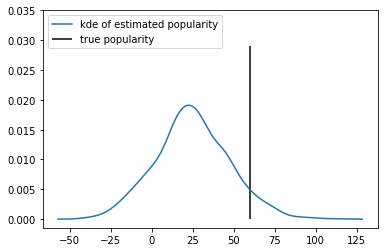

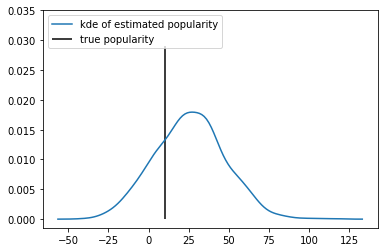

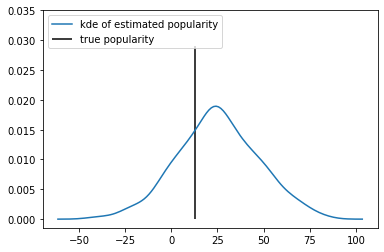

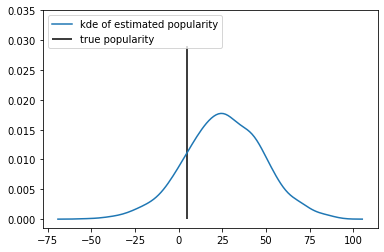

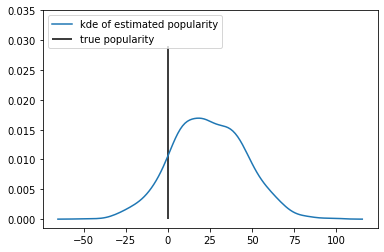

In [28]:
# Show posterior distributions for a few values
y_ex = bnn.predict(torch.from_numpy(X_test[:5]).float(), n_samples=1000)
for y_pred, y_true in zip(np.array(y_ex).T, y_test[:5]):
    kdeplot(y_pred, label='kde of estimated popularity')
    plt.vlines(y_true, 0, 0.029, label='true popularity')
    plt.ylim(top=0.035)
    plt.legend(loc='upper left')
    plt.show()

Results for variational inference methods don't look very good rn. I think there's either something important about the software I'm missing, or it may just be inadequate for this problem.

### Now for k-fold cross-validation on logit model

In [29]:
# Load in data and create folds

my_df = pd.concat(pd.read_csv(os.path.join('data', 'my_data', filename), index_col=0) \
                 for filename in os.listdir('data/my_data'))

# change data type on a couple of variables
my_df['explicit'] = my_df['explicit'].astype('int')
my_df['release_date'] = pd.to_datetime(my_df['release_date'], yearfirst=True)


# Modify some variables so they make more sense in regression context

# is 4:4?
my_df['time_signature_4'] = (my_df['time_signature'] == 4).astype('int')
# difference between data collection date and release date
my_df['days_since_release'] = (pd.to_datetime('2020-03-11') - my_df['release_date']).apply(lambda x: x.days)
# Express durations in seconds, not milliseconds
my_df['duration_s'] = my_df['duration_ms'] / 1000

# drop messed up entries
my_df.dropna(inplace=True)
# shuffle mydf
my_df = my_df.sample(frac=1, random_state=152).reset_index(drop=True)

df_sample = df.sample(2000, random_state=152)
my_df['is_favorite'] = 1
df_sample['is_favorite'] = 0

# Construct folds
combined_X = []
combined_y = []
reserved = pd.DataFrame()

logit_features = features + ['popularity']

# Compute scaling mean and stdev
X_ = pd.concat((my_df, df_sample))[logit_features].values
means = X_.mean(axis=0)
stdevs = X_.std(axis=0)
y_ = pd.concat((my_df, df_sample))['is_favorite'].values

n_folds = 5
leave_out_size = 15
for k in range(5):
    # Exclude same number of songs from my songs and other songs
    my_to_reserve = my_df.iloc[k*leave_out_size:(k+1)*leave_out_size].copy()
    df_sample_to_reserve = df_sample.iloc[k*leave_out_size:(k+1)*leave_out_size].copy()
    to_reserve = pd.concat((my_to_reserve, df_sample_to_reserve))
    to_reserve['fold'] = k
    reserved = pd.concat((reserved, to_reserve))
    my_df_sub = my_df.loc[my_df.index.difference(my_to_reserve.index)]
    df_sample_sub = df_sample.loc[df_sample.index.difference(df_sample_to_reserve.index)]
    # use smaller subset of df_sample
    combined_df = pd.concat((my_df_sub, df_sample_sub))
    combined_df = combined_df[~combined_df.index.duplicated(keep='first')]
    # add data to list of data sets, pre-scaling
    combined_X.append((combined_df[logit_features].values - means) / stdevs)
    combined_y.append(combined_df['is_favorite'].values)

reserved.to_csv('reserved_data.csv')

In [30]:
# make same model as in stan_models, although remove data scaling
# data will be pre-scaled

logit_model_str = '''
data {
  int<lower=0> N;
  int<lower=0> K;
  matrix[N, K] X;
  int<lower=0,upper=1> y[N];
}

parameters {
  real alpha;
  vector[K] beta;
}

model {
  // likelihood
  y ~ bernoulli_logit(alpha + X * beta);
}
'''

model_file = 'crossval_logit_model.pkl'
if os.path.isfile(model_file):
    with open(model_file, 'rb') as fh:
        model = pickle.load(fh)
else:
    model = pystan.StanModel(model_code=logit_model_str)
    with open(model_file, 'wb') as fh:
        pickle.dump(model, fh)

for k, X, y in zip(range(n_folds), combined_X, combined_y):
    data = {
        'N': X.shape[0],
        'K': X.shape[1],
        'X': X,
        'y': y
    }
    
    fit_file = f'crossval_logit_fit{k}.pkl'
    if os.path.isfile(fit_file):
        with open(fit_file, 'rb') as fh:
            logit_fit = pickle.load(fh)
    else:
        logit_fit = model.sampling(data=data, iter=5000, warmup=2000, chains=2)
        with open(fit_file, 'wb') as fh:
            pickle.dump(logit_fit, fh)

In [31]:
print(logit_fit.stansummary())

Inference for Stan model: anon_model_827be891ce74506adaf9304260f19044.
2 chains, each with iter=5000; warmup=2000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=6000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       -4.3  3.1e-3   0.22  -4.74  -4.44  -4.29  -4.15  -3.88   5087    1.0
beta[1]     0.26  1.4e-3   0.13 2.8e-3   0.17   0.25   0.35   0.52   9267    1.0
beta[2]     -1.0  2.0e-3   0.19  -1.42  -1.12  -0.99  -0.86  -0.64   9389    1.0
beta[3]    -1.68  2.5e-3   0.22  -2.14  -1.83  -1.68  -1.52  -1.27   7985    1.0
beta[4]     -0.5  1.4e-3   0.14   -0.8  -0.59   -0.5  -0.41  -0.24   9851    1.0
beta[5]    -0.48  1.4e-3   0.13  -0.76  -0.57  -0.48  -0.39  -0.23   8873    1.0
beta[6]     0.45  1.6e-3   0.14   0.18   0.36   0.45   0.54   0.71   7145    1.0
beta[7]     0.38  2.5e-3    0.2  -0.02   0.24   0.38   0.51   0.78   6501    1.0
beta[8]    -0.71  2.2e-3   0.18  -1.06  -0.83  -0.71  -0.59  -0.35   6689    1.0
b

In [32]:
# code for the same thing using pymc3
# import pymc3 as pm

# def get_trace(X, y):
#     with pm.Model() as logistic_model:
#         # use uninformative priors as in stan model
#         alpha = pm.Normal('alpha', mu=0, sigma=100)
#         beta = pm.Normal('beta', mu=0, sigma=100, shape=X.shape[1])
#         # calculate logits
#         logits = alpha + pm.math.dot(X, beta)
#         obs = pm.Bernoulli('obs', logit_p=logits, observed=y)
#         # Get trace using NUTS
#         return pm.sample(3000, tune=2000)

# X_ = (pd.concat((my_df, df_sample))[logit_features].values - means) / stdevs
# y_ = pd.concat((my_df, df_sample))['is_favorite'].values

# logit_trace = get_trace(X_, y_)
# for k, X, y in zip(range(n_folds), combined_X, combined_y):

#     trace_file = f'crossval_logit_trace{k}.pkl'
#     if os.path.isfile(trace_file):
#         with open(trace_file, 'rb') as fh:
#             logit_trace = pickle.load(fh)
#     else:
#         logit_trace = get_trace(X, y)
#         with open(trace_file, 'wb') as fh:
#             pickle.dump(logit_trace, fh)

In [33]:
from scipy.special import logit, expit
from scipy.stats import bernoulli

def compute_diagnostics(fold, nsamp=100):
    logit_fit_file = f'crossval_logit_fit{fold}.pkl'
    data = reserved[reserved['fold'] == fold]
    # load data and normalize
    X = (data[logit_features].values - means) / stdevs
    y = data['is_favorite'].values
    with open(logit_fit_file, 'rb') as fh:
        logit_fit = pickle.load(fh)
    params = logit_fit.extract(pars=['alpha', 'beta'])
    nparams = len(params['alpha'])
    # get samples
    # draw random sample of indices
    nrow = X.shape[0]
    indices = np.random.choice(nparams, nrow*nsamp, replace=True)
    alpha = params['alpha'][indices].reshape(nrow, nsamp)
    beta = params['beta'][indices].reshape(nrow, nsamp, -1)
    # Compute ratios for rare event correction
    pop_ratio = combined_y[fold].mean()
    samp_ratio = y.mean()
    logits = alpha + logit(samp_ratio) - logit(pop_ratio)
    for i in range(nrow):
        for j in range(nsamp):
            logits[i,j] += X[i].dot(beta[i,j,:])
    probs = expit(logits).mean(axis=1)
    prob_correct = bernoulli.pmf(y, p=probs)
    accuracy = prob_correct.mean()
    # Calculate ppd
    ppd = np.log(prob_correct).mean()
    return accuracy, ppd

def check_train(X, y, nsamp=10):
    params = logit_fit.extract(pars=['alpha', 'beta'])
    nparams = len(params['alpha'])
    # get samples
    # draw random sample of indices
    nrow = X.shape[0]
    indices = np.random.choice(nparams, nrow*nsamp, replace=True)
    alpha = params['alpha'][indices].reshape(nrow, nsamp)
    beta = params['beta'][indices].reshape(nrow, nsamp, -1)
    # No need for correction factor
    logits = alpha
    for i in range(nrow):
        for j in range(nsamp):
            logits[i,j] += X[i].dot(beta[i,j,:])
    probs = expit(logits).mean(axis=1)
    prob_correct = bernoulli.pmf(y, p=probs)
    accuracy = prob_correct.mean()
    # Calculate ppd
    ppd = np.log(prob_correct).mean()
    return accuracy, ppd
    

In [34]:
# Accuracy and ppd on test data
acc = 0
ppd = 0
for k in range(5):
    acc_, ppd_ = compute_diagnostics(k)
    print(acc_, ppd_)
    acc += acc_
    ppd += ppd_

print(f'average accuracy: {acc / 5}')
print(f'average ppd: {ppd / 5}')

0.7123428254637786 -0.4411401642244575
0.7372463784194351 -0.4020231031623062
0.7863282765360476 -0.2923496339513966
0.6082891596453559 -0.7149925127779011
0.7499449258774631 -0.38390692841423607
average accuracy: 0.718830313188416
average ppd: -0.44688246850605956


In [35]:
# Accuracy and ppd on train data
acc = 0
ppd = 0
for k in range(5):
    acc_, ppd_ = check_train(combined_X[k], combined_y[k])
    print(acc_, ppd_)
    acc += acc_
    ppd += ppd_

print(f'average accuracy: {acc / 5}')
print(f'average ppd: {ppd / 5}')

0.9000578028802577 -0.17508072548134998
0.8993775210857092 -0.1768409221081898
0.900391748282753 -0.1745979188177359
0.9011213906269835 -0.17094710007775607
0.8998401031365354 -0.17450996273458688
average accuracy: 0.9001577132024478
average ppd: -0.17439532584392373
